In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from pylab import *
import matplotlib
#import plplot
from scipy import stats#from io import StringIO
print(pd.__version__)
#AttributeError: 'Series' object has no attribute 'to_numpy'
import re

import math
import astropy as astro
import scipy.ndimage as spimage
from astropy.io import fits, ascii
from astropy.table import Table, join, vstack
from astropy.cosmology import WMAP9 as cosmo
import matplotlib as mpl
#from numpy import std as biweight_midvariance
import matplotlib.cm as cm

from scipy import optimize
import scipy.stats as stats
from scipy.stats import gaussian_kde
from matplotlib import colors
import scipy.ndimage as ndimage
from collections import Counter
from matplotlib.legend import Legend
import matplotlib.patches as patches
from matplotlib import pyplot
#
#
#
import extinction


#
# seaborn
# import pandas.util.testing as tm
import seaborn as sns

#
# Jorge
#

from sel2dhist_xy import sel2dhist_xy


#
# 3D plots!
#
import numpy as np
import scipy.linalg
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

#biweight_midvariance


import warnings
warnings.simplefilter("ignore")

#
# my_utils
#
from my_utils import *

#
#
#
from ndtest import *
from sklearn.decomposition import PCA

#
#
#
from scipy.optimize import leastsq, fmin
import matplotlib.animation as animation

#
# Carlos Color map
#
from cmaps_CLC import vel_map



/home/sanchez/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/tmp/ipykernel_4193/3096247204.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


2.2.0
2.2.0


In [2]:

def search_col(tab,key):
    for cols in tab.columns:
        if (cols.find(key)>-1):
            print(cols)

In [3]:
import matplotlib.colors as mcolors
color_cm_now = vel_map()
f = open('colortables/CLC_vmap.csv', 'w')
for i in range(color_cm_now.N):
    val=color_cm_now(i)
    val_str=f'{val[0]},{val[1]},{val[2]},{val[3]}\n'
#    f.write("Hello, World!\n")
#    print(val_str)
    f.write(val_str);
f.close()
#color_list = [mcolors.rgb2hex(color_cm_now(i)) for i in range(color_cm_now.N)]
#print(color_list)

In [4]:
from matplotlib import rcParams as rc
rc.update({'font.size': 18,\
           'font.weight': 900,\
           'text.usetex': True,\
           'path.simplify'           :   True,\
           'xtick.labelsize' : 18,\
           'ytick.labelsize' : 18,\
#           'xtick.major.size' : 3.5,\
#           'ytick.major.size' : 3.5,\
           'axes.linewidth'  : 2.0,\
               # Increase the tick-mark lengths (defaults are 4 and 2)
           'xtick.major.size'        :   6,\
           'ytick.major.size'        :   6,\
           'xtick.minor.size'        :   3,\
           'ytick.minor.size'        :   3,\
           'xtick.major.width'       :   1,\
           'ytick.major.width'       :   1,\
           'lines.markeredgewidth'   :   1,\
           'legend.numpoints'        :   1,\
           'xtick.minor.width'       :   1,\
           'ytick.minor.width'       :   1,\
           'legend.frameon'          :   False,\
           'legend.handletextpad'    :   0.3,\
           'font.family'    :   'serif',\
           'mathtext.fontset'        :   'stix',\
           'axes.facecolor' : "w",\
           
          })


In [5]:
##########################################################################
# We read the KG-Pipe3D catalog
##########################################################################
hdu = fits.open('tables/KG_Pipe3D_table_COSMO.fits')
tab_KG = Table(hdu[1].data)
tab_KG.rename_column('name','org_name')
tab_KG.rename_column('cubename','name')

In [6]:
def get_image_table(ra,dec,filters="grizy"):
    """
    Query ps1filenames.py service to get a list of images
    
    ra, dec = position in degrees
    filters = string with filters to include. includes all by default
    Returns a table with the results
    """
    service = "https://ps1images.stsci.edu/cgi-bin/ps1filenames.py"
    # The final URL appends our query to the PS1 image service
    url = f"{service}?ra={ra}&dec={dec}&filters={filters}"
    # Read the ASCII table returned by the url
    table = Table.read(url, format='ascii')
    return table


def get_imurl(ra, dec, size=240, output_size=None, filters="grizy", im_format="jpg", color=False):
    """
        Get URL for images in the table
        
        ra, dec = position in degrees
        size = extracted image size in pixels (0.25 arcsec/pixel)
        output_size = output (display) image size in pixels (default = size).
                      output_size has no effect for fits format images.
        filters = string with filters to include. choose from "grizy"
        format = data format (options are "jpg", "png" or "fits")
        color = if True, creates a color image (only for jpg or png format).
                Default is return a list of URLs for single-filter grayscale images.   
        Returns a string with the URL
    """
    # Check for user input errors
        
    if color and (im_format == "fits"):
        raise ValueError("color images are available only for jpg or png formats")
    if im_format not in ("jpg","png","fits"):
        raise ValueError("format must be one of jpg, png, fits")
            
    # Call the original helper function to get the table
    table = get_image_table(ra,dec,filters=filters)
    url = (f"https://ps1images.stsci.edu/cgi-bin/fitscut.cgi?"
           f"ra={ra}&dec={dec}&size={size}&format={im_format}")
        
    # Append an output size, if requested
    if output_size:
        url = url + f"&output_size={output_size}"
            
    # Sort filters from red to blue
    flist = ["yzirg".find(x) for x in table['filter']]
    table = table[np.argsort(flist)]
        
    if color:
        # We need at least 3 filters to create a color image
        if len(table) < 3:
            raise ValueError("at least three filters are required for an RGB color image")
        # If more than 3 filters, pick 3 filters from the availble results
        if len(table) > 3:
            table = table[[0,len(table)//2,len(table)-1]]
        # Create the red, green, and blue files for our image
        for i, param in enumerate(["red","green","blue"]):
            url = url + f"&{param}={table['filename'][i]}"
       
    else:
        # If not a color image, only one filter should be given.
        if len(table)>1:
            warnings.warn('Too many filters for monochrome image. Using only 1st filter.')
        # Use red for monochrome images
        urlbase = url + "&red="
        url = []
        filename = table[0]['filename']
        url = urlbase+filename
    return url


def get_im(ra, dec, size=240, output_size=None, filters="g", im_format="jpg", color=False):
    """
        Get image at a sky position. Depends on get_imurl
        
        ra, dec = position in degrees
        size = extracted image size in pixels (0.25 arcsec/pixel)
        output_size = output (display) image size in pixels (default = size).
                      output_size has no effect for fits format images.
        filters = string with filters to include
        format = data format (options are "jpg", "png")
        Returns the image
    """
    # For either format, we need the image URL
    url = get_imurl(ra,dec,size=size,filters=filters,output_size=output_size,im_format=im_format,color=color)
    #print(url)
    if im_format == "fits":
        fh = fits.open(url)
        # The image is contained within the data unit
        fits_im = fh[0].data
        # Set contrast to something reasonable
        #transform = AsinhStretch() + PercentileInterval(99.5)
        im = fits_im
        hdr = fh[0].header
        #fh.info()
    else:
        # JPEG is easy. Request the file, read the bytes
        r = requests.get(url)
        im = Image.open(BytesIO(r.content))
    return im,hdr

In [7]:
from astroquery.skyview import SkyView
import os
from astropy import units as u

# Create the directory to store PanSTARRS images if it doesn't exist
output_dir = 'PanStarss'
os.makedirs(output_dir, exist_ok=True)

# Loop through the rows in tab_KG
for row in tab_KG:
    cube_file = f"data/{row['name']}.Pipe3D.cube.fits.gz"
    if os.path.exists(cube_file):  # Check if the datacube file exists
        ra, dec = row['RA'], row['DEC']
        target_name = row['name']
        print(f"Processing {target_name} at RA: {ra}, DEC: {dec}")

        
        # Query Pan-STARRS for a g-band image
        try:
            images,hdr = get_im(ra,dec,size=100,filters="g",im_format='fits')
            print(target_name, images.shape)
            output_path = os.path.join(output_dir, f"{target_name}_g.fits")
            hdu = fits.PrimaryHDU(images, header=hdr)
            hdu.writeto(output_path, overwrite=True)
            print(f"Saved: {output_path}")
        except Exception as e:
            print(f"Error retrieving image for {target_name}: {e}")

Processing KG-MaNGA-1-207 at RA: 145.59402465820312, DEC: 0.3094100058078766
KG-MaNGA-1-207 (100, 100)
Saved: PanStarss/KG-MaNGA-1-207_g.fits
Processing KG-SAMI-107214 at RA: 218.89645385742188, DEC: 0.8888300061225891
KG-SAMI-107214 (100, 100)
Saved: PanStarss/KG-SAMI-107214_g.fits
Processing KG-SAMI-93023 at RA: 218.54690551757812, DEC: 0.6157500147819519
KG-SAMI-93023 (100, 100)
Saved: PanStarss/KG-SAMI-93023_g.fits
Processing KG-SAMI-63777 at RA: 216.88217163085938, DEC: -0.29012998938560486
KG-SAMI-63777 (100, 100)
Saved: PanStarss/KG-SAMI-63777_g.fits


KG-MaNGA-1-207 145d35m38.81632295s 0d18m33.62817129s 145d35m38.65588123s 0d18m33.74140238s 0.1604417241878764 -0.11323109056822211 0.1963742007791439
KG-SAMI-107214 218d53m47.39994225s 0d53m19.5417594s 218d53m47.09608851s 0d53m19.81351542s 0.3038537394559171 -0.271756018086311 0.40764988451791784
KG-SAMI-93023 218d32m48.92711697s 0d36m56.71739781s 218d32m49.04131211s 0d36m56.654161s -0.114195144169571 0.06323680598083747 0.13053514692437124
KG-SAMI-63777 216d52m55.9118502s -0d17m24.5884289s 216d52m55.76275941s -0d17m24.32478412s 0.14909078229266015 -0.26364477845675083 0.3028805549587933


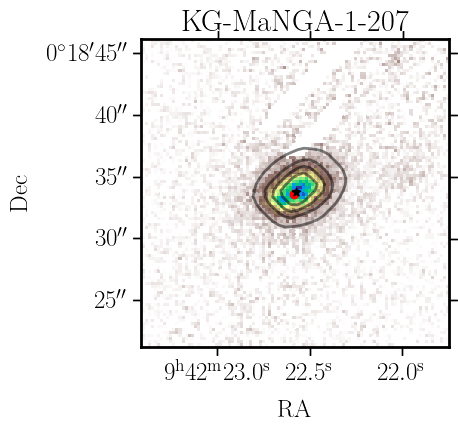

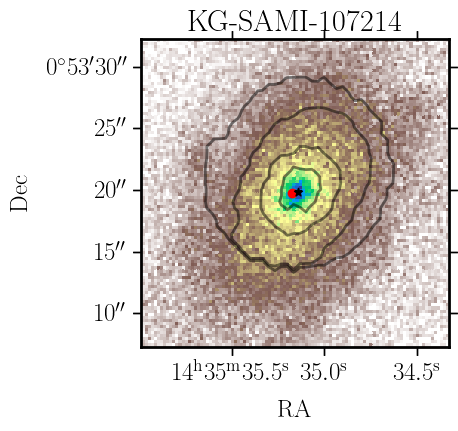

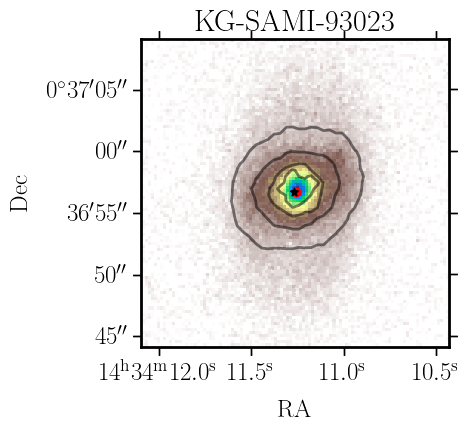

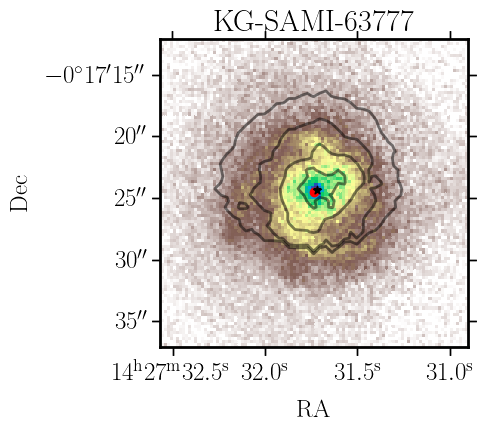

In [15]:
from astropy.wcs import WCS
from matplotlib import pyplot as plt
from astropy.visualization import simple_norm
import numpy as np
from scipy.ndimage import center_of_mass
# Loop through the rows in tab_KG



tab_out = Table(names=('name', 'RA_img', 'DEC_img', 'RA_cube', 'DEC_cube', 'dRA', 'dDEC', 'delta'),
                dtype=('str', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64'))


for row in tab_KG:
    target_name = row['name']
    cube_file = f"data/{row['name']}.Pipe3D.cube.fits.gz"
    g_band_file = os.path.join(output_dir, f"{row['name']}_g.fits")
    
    if os.path.exists(cube_file) and os.path.exists(g_band_file):  # Check if both files exist
        try:
            # Open the g-band image
            g_band_hdu = fits.open(g_band_file)
            g_band_data = g_band_hdu[0].data
            g_band_wcs = WCS(g_band_hdu[0].header)
            
            # Open the Pipe3D datacube
            cube_hdu = fits.open(cube_file)
            ssp_data = cube_hdu['SSP'].data[0]  # Use the 1st slice of the SSP extension
            if (target_name.find('SAMI')>-1):
                cube_hdu[0].header['CD1_1'] = -0.000138889
                cube_hdu[0].header['CD2_2'] = 0.000138889
            cube_wcs = WCS(cube_hdu[0].header)
            
            # Normalize the g-band image for better visualization
            norm = simple_norm(g_band_data, 'linear', percent=99)
            
            # Create the plot
            plt.figure(figsize=(4, 4))
            ax = plt.subplot(projection=g_band_wcs)
            vmin = np.nanmin(g_band_data[g_band_data>0])
            vmax = np.nanmax(g_band_data[g_band_data>0])
            ax.imshow(g_band_data, origin='lower', cmap='terrain_r', vmax=vmax, vmin=vmin, transform=ax.get_transform(g_band_wcs),\
                      interpolation='None')
            ax.set_title(f"{row['name']}")
            ax.set_xlabel('RA')
            ax.set_ylabel('Dec')
            
            #print(g_band_wcs)

            # Overplot the contours using the SSP data
            levels = np.linspace(np.nanmin(ssp_data[ssp_data>0]), np.nanmax(ssp_data[ssp_data>0]), 6)
            levels = levels[1:]  # Exclude the first and last levels for better visualization
            plane_wcs = cube_wcs.dropaxis(2)
            #print(g_band_wcs, cube_wcs, plane_wcs)
            ax.contour(ssp_data, levels=levels, transform=ax.get_transform(cube_wcs.dropaxis(2)), colors='black', linewidths=2, alpha=0.5)
            
            # Calculate the barycenter in pixel coordinates
            y, x = np.indices(g_band_data.shape)
            center = np.array(g_band_data.shape) / 2
            radius = np.sqrt((x - center[1])**2 + (y - center[0])**2)
            max_radius = np.min(center)
            distance_mask = radius < 10/0.25
            mask_img = np.where((np.isfinite(g_band_data) & ~np.isnan(g_band_data) & 
                                 (g_band_data > 3 * np.nanstd(g_band_data)) & distance_mask), 1, 0)
#            print(mask_img.shape)
            # Mask the wrong values in the g-band data
            g_band_data = np.where((g_band_data > 0) & np.isfinite(g_band_data), g_band_data, 0)
            bc_img = np.array(center_of_mass((g_band_data**4) * mask_img)) - 0.5
            # Convert the pixel coordinates to physical coordinates using WCS
            bc_img_p = g_band_wcs.pixel_to_world(bc_img[1], bc_img[0])
            y, x = np.indices(ssp_data.shape)
            center = np.array(ssp_data.shape) / 2
            radius = np.sqrt((x - center[1])**2 + (y - center[0])**2)
            distance_mask = radius < 10/0.5
            # Calculate the barycenter in pixel coordinates 
            mask_cube = np.where(np.isfinite(ssp_data) & ~np.isnan(ssp_data) & \
                                 (ssp_data > 3*np.nanstd(ssp_data)) & distance_mask, 1, 0)
            bc_cube = np.array(center_of_mass(ssp_data**4*mask_cube)) - 0.5
            # Convert the pixel coordinates to physical coordinates using WCS
            bc_cube_p = plane_wcs.pixel_to_world(bc_cube[1], bc_cube[0])
            bc_cube_img = g_band_wcs.world_to_pixel(bc_cube_p)
            #print(bc_img_p.ra, bc_img_p.dec, bc_cube_p.ra, bc_cube_p.dec)
            ax.scatter(bc_img[0],bc_img[1], marker='o', color='red')
            ax.scatter(bc_cube_img[0],bc_cube_img[1], marker='*', color='black')
            d_bc_RA = 3600.0*(bc_img_p.ra.deg-bc_cube_p.ra.deg)
            d_bc_DEC = 3600.0*(bc_img_p.dec.deg-bc_cube_p.dec.deg)
            d_bc = 3600.0*np.sqrt((bc_img_p.ra.deg-bc_cube_p.ra.deg)**2 + (bc_img_p.dec.deg-bc_cube_p.dec.deg)**2)
            tab_out.add_row((target_name, bc_img_p.ra.deg, bc_img_p.dec.deg, bc_cube_p.ra.deg, bc_cube_p.dec.deg, d_bc_RA, d_bc_DEC, d_bc))
            print(target_name, bc_img_p.ra, bc_img_p.dec,  bc_cube_p.ra, bc_cube_p.dec , d_bc_RA, d_bc_DEC, d_bc)
            plt.savefig(f"PS_img/{target_name}_KG.pdf", transparent=False, facecolor='white', edgecolor='white')#.pdf")
            #plt.show()
        except Exception as e:
            print(f"Error processing {row['name']}: {e}")

In [140]:
tab_out.write('tables/PS_img_barycenter.fits', format='fits', overwrite=True)